In [53]:
%matplotlib notebook

import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import database
from snowballing.operations import reload, work_by_varname, load_work_map_all_years
from snowballing.strategies import Strategy, State
from functools import reduce
from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt
import pandas as pd

reload()
# !pip install matplotlib-venn

In [2]:
from snowballing.operations import metakey, metakey_title

def busca(*libraries, seed=None, filter_function=None):
    filter_function = filter_function or (lambda x: x.category in ("snowball",))
    if seed is not None:
        iterable = ((1, work_by_varname(x)) for x in seed)
    else:
        iterable = load_work_map_all_years()
    seedset = set()
    visited = set()
    for _, work in iterable:
        for library in libraries:
            if int(getattr(work, library, 0)):
                visited.add(work)
                if filter_function(work):
                    seedset.add(work)
                break
    return seedset, filter_function, visited

def descreve_delta(strategy, state, name):
    target = state.find(name)
    previous_related = reduce(lambda x, y: x | y, (s.related for s in target.previous[0]), set())
    for work in previous_related:
        backward = set(strategy.ref[work]) & target.delta_visited
        if backward:
            print('backward', work.metakey)
            for ref in backward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')
        forward = set(strategy.rev_ref[work]) & target.delta_visited
        if forward:
            print('forward', work.metakey)
            for ref in forward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')

def separa_backward_forward(state):
    backward = set()
    forward = set()
    stack = [state]
    visited = {id(state)}
    while stack:
        current = stack.pop()
        if current.previous:
            if current.previous[1] == "backward":
                backward |= current.delta_related
            if current.previous[1] == "forward":
                forward |= current.delta_related
                
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.append(previous)
    return backward, forward

def encontraria(strategy, state):
    backward = set()
    forward = set()
    related = state.related - state.find("s0").related
    for work in state.related:
        backward |= (set(strategy.ref[work]) & related)
        forward |= (set(strategy.rev_ref[work]) & related)
    return backward, forward

#busca("scopus", seed=["wohlin2014a", "briand2000a"], filter_function=lambda x: True)
#busca("scopus", filter_function=lambda x: False)

# Estratégias

## Estratégia 1 - Busca em todas Digital Libraries (DL)

In [3]:
print ("Total de estudos primários usados como Seed Set: ", len ([x for _, x in load_work_map_all_years() if x.category == "snowball"]))


Total de estudos primários usados como Seed Set:  22


In [4]:
print ("Lista de estudos primários usados como Seed Set:")
([x for _, x in load_work_map_all_years() if x.category == "snowball"])

Lista de estudos primários usados como Seed Set:


[Exploring the use of the cynefin framework to inform software development approach decisions,
 An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI),
 Strategically balanced process adoption,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Defining and monitoring strategically aligned software improvement goals,
 Linking software development and business strategy through measurement,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 Utilizing GQM+ Strategies for an organization-wide earned value analysis,
 Utilizing GQM+ Strategies for business value analysis: An approach for evaluating business goals,
 Software process improvement: Supporting the linking of the software and the business strategies,
 Entropy based software processe

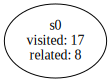

In [5]:
reload()
TOTAL = [x for _, x in load_work_map_all_years() if x.category == "snowball"]
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))

state = strategy.initial
strategy.initial.visited

#strategy.initial.name
state


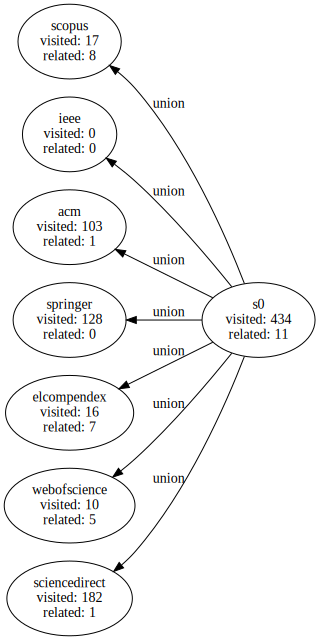

In [6]:
from snowballing.strategies import State

reload()
def busca_completa(libs, filter_function):
    union = None
    for dl in libs:
        strategy = Strategy(*busca(dl, filter_function=filter_function))
        strategy.initial.name = dl
        if union is None:
            union = strategy.initial.derive("union", name="s0")
        else:
            union.visited.update(strategy.initial.visited)
            union.related.update(strategy.initial.related)
            union.previous[0].append(strategy.initial)

    State.last_id = 0
    strategy.initial = union
    return strategy

strategy = busca_completa(["scopus", "ieee", "acm", "springer", "elcompendex", "webofscience", "sciencedirect"], filter_function)
#strategy.initial.find("acm")
strategy.initial

In [7]:
array = []

name = "E1"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E1
0.47058823529411764
Recall E1
0.36363636363636365


## Estratégia 2 - Busca em todas Digital Libraries + Snowballing (Guideline - sfbu)

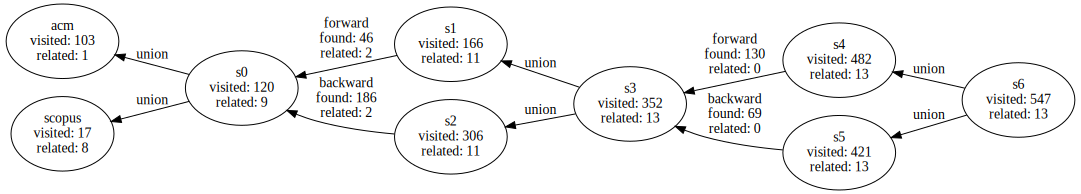

In [8]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = busca_completa(["acm", "scopus"], filter_function)
#Strategy(*busca("acm","scopus", filter_function=filter_function))

state = strategy.sfbu()
#state = strategy.bbff()
#state = strategy.ffbb()
#state = strategy.s2ffbb2u()

state

### Resumo 

#### Resumo da Busca em DL

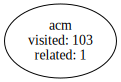

In [11]:
strategy.initial.find("acm")

In [12]:
# Visitados ACM
strategy.initial.find("acm").visited

{Thinkflickrthink: A Case Study on Strategic Tagging,
 Capturing Social Value in UX Projects,
 ROCKIT: Roadmap for Conversational Interaction Technologies,
 Business-oriented IT Management: Developing e-Business Applications with E-BPMS,
 Language, Culture and Boundary-spanning: Pushing the Frontiers of Research on Global Learning and Innovation,
 Aligning Business Goals and User Goals by Engineering Hedonic Quality,
 Object Associations: A Simple and Practical Approach to Virtual 3D Manipulation,
 Healthy Technology,
 A Systematic Review of Business and Information Technology Alignment,
 Experience with Adapting a WS-BPEL Runtime for eScience Workflows,
 Strategy Recommender Agents (ALEX) - the Methodology,
 A Contingency View of Organizational Infrastructure Requirements Engineering,
 Current Research Trends and Directions for Future Research in Trust Maintenance for Virtual Environments,
 Probabilistic Bug Localization via Statistical Inference Based on Partially Observed Data,
 Net

In [13]:
# Relacionados ACM - encontrado no seed set
strategy.initial.find("acm").related

{Utilizing GQM+ Strategies for business value analysis: An approach for evaluating business goals}

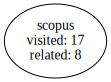

In [14]:
strategy.initial.find("scopus")

In [17]:
print("Visitados Scopus:")
strategy.initial.find("scopus").visited

Visitados Scopus:


{Alignment between the business strategy and the software processes improvement: A roadmap for the implementation [Alinhamento entre estrategia de negocios e melhoria de processos de software: Um roteiro de implementacao],
 ProPAMet: a Metric for process and project alignment,
 Using strategic planning for selection of SPI processes: An experience report,
 Empirical evaluation of selected best practices in implementation of software process improvement,
 Software process improvement: Supporting the linking of the software and the business strategies,
 An approach to support the strategic alignment of software process improvement programs,
 Critical success factors in software process improvement: A systematic review,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 A case study applying process and

In [20]:
print("Relacionados Scopus - encontrado no seed set:")
strategy.initial.find("scopus").related

Relacionados Scopus - encontrado no seed set:


{SPI:I can't get no satisfaction-directing process improvement to meet business needs,
 ProPAMet: a Metric for process and project alignment,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Software process improvement: Supporting the linking of the software and the business strategies,
 An approach to support the strategic alignment of software process improvement programs,
 A Low-overhead method for software process appraisal,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry}

In [22]:
print("Artigo comum a ACM e Scopus:")
strategy.initial.find("acm").visited & strategy.initial.find("scopus").visited

Artigo comum a ACM e Scopus:


set()

#### Resumo do Snowballing

In [23]:
#Total de visitados = visitados no final - visitados no início
print ("Total visitados:")
len(state.visited - state.find("s0").visited)

Total visitados:


427

In [24]:
# Descrição dos Relacionados = relacionados no final - relacionados no início
print ("Total Relacionados: Lista dos que foram encontrados via Snowballing")
state.related - state.find("s0").related

Total Relacionados: Lista dos que foram encontrados via Snowballing


{An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI),
 Entropy based software processes improvement,
 Utilizing GQM+ Strategies for an organization-wide earned value analysis,
 Linking software development and business strategy through measurement}

In [25]:
print ("Encontrados via somente Snowballing:")
diff_related = state.related - state.find("s0").related
diff_related @ metakey_title

Encontrados via somente Snowballing:


['petersen2015a - An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI)',
 'trienekens2009a - Entropy based software processes improvement',
 'mandić2010a - Utilizing GQM+ Strategies for an organization-wide earned value analysis',
 'basili2010a - Linking software development and business strategy through measurement']

### Detalhamento por Estado / Aresta

#### Estado S0

#### Visitados

In [26]:
#S0 - Visitados
print("Visitados no Estado 0:")
state.find("s0").visited

Visitados no Estado 0:


{Thinkflickrthink: A Case Study on Strategic Tagging,
 Capturing Social Value in UX Projects,
 ROCKIT: Roadmap for Conversational Interaction Technologies,
 Business-oriented IT Management: Developing e-Business Applications with E-BPMS,
 Language, Culture and Boundary-spanning: Pushing the Frontiers of Research on Global Learning and Innovation,
 Aligning Business Goals and User Goals by Engineering Hedonic Quality,
 Object Associations: A Simple and Practical Approach to Virtual 3D Manipulation,
 Healthy Technology,
 A Systematic Review of Business and Information Technology Alignment,
 Experience with Adapting a WS-BPEL Runtime for eScience Workflows,
 Strategy Recommender Agents (ALEX) - the Methodology,
 A case study applying process and project alignment methodology,
 A Contingency View of Organizational Infrastructure Requirements Engineering,
 Current Research Trends and Directions for Future Research in Trust Maintenance for Virtual Environments,
 Probabilistic Bug Localizatio

#### Relacionados - Seed Set

In [27]:
#S0 - Relacionados - Encontrados via busca e que existem na lista dos Incluídos da SLR existente - são os seed set!
print("Relacionados no Estado 0: Seed Set")
state.find("s0").related @ metakey_title

Relacionados no Estado 0: Seed Set


["reiblein1997a - SPI:\x91I can't get no satisfaction\x92-directing process improvement to meet business needs",
 'martins2008a - ProPAMet: a Metric for process and project alignment',
 'plösch2011a - Software engineering strategies: aligning software process improvement with strategic goals',
 'albuquerque2009a - Software process improvement: Supporting the linking of the software and the business strategies',
 'becker2008a - An approach to support the strategic alignment of software process improvement programs',
 'wilkie2007a - A Low-overhead method for software process appraisal',
 'guzmán2010a - Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations',
 'mandić2010b - Utilizing GQM+ Strategies for business value analysis: An approach for evaluating business goals',
 'kaneko2011a - Application of GQM+ Strategies{\textregistered} in the Japanese space industry']

#### Aresta s0 -> s2 (Backward - Iteração 1)

In [28]:
# S2 - Backward (Found) - Visitados na iteração 1
print("Backward - Qtd Referencias dos artigos visitados para chegar ao Estado 2, a partir do Estado 0:")
state.find("s2").delta_visited

Backward - Qtd Referencias dos artigos visitados para chegar ao Estado 2, a partir do Estado 0:


{Connecting strategy and competitive intelligence: Refocusing intelligence to produce critical strategy inputs,
 The impact of institutional forces on software metrics programs,
 Value-based software engineering: A case study,
 The office of strategy management,
 Bridging the gap between business strategy and software development,
 The capability maturity model: Guidelines for improving the software process,
 Guide to Software Quality Management System Construction and Certification,
 ITIL - The Information Technology Infrastructure Library,
 Using PEST analysis as a tool for refining and focusing contexts for information systems research.,
 Applying QFD for software process improvement at SAP AG,
 Interfacing three complementary technologies: Strategic planning, process modeling, and system dynamics,
 Risk analysis of software process measurements,
 Information Technology - Amendment 2 to ISO/IEC 12207,
 The balanced scorecard--measures that drive performance,
 Information technology 

In [29]:
# S2 - Backward (Related) - Encontrados na iteração 1, via snowballing, que não foi encontrado via busca para o seed set.
print("Relacionados encontrados via Backward, para chegar ao Estado 2, a partir do Estado 0:")
state.find("s2").delta_related @ metakey_title

Relacionados encontrados via Backward, para chegar ao Estado 2, a partir do Estado 0:


['trienekens2009a - Entropy based software processes improvement',
 'basili2010a - Linking software development and business strategy through measurement']

#### Aresta s0 -> s1 (Forward - Iteração 1)

In [30]:
# S1 - Forward (Related) - Encontrados na iteração 1
print("Relacionados encontrados via Forward, para chegar ao Estado 1, a partir do Estado 0:")
state.find("s1").delta_related @ metakey_title

Relacionados encontrados via Forward, para chegar ao Estado 1, a partir do Estado 0:


['petersen2015a - An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI)',
 'mandić2010a - Utilizing GQM+ Strategies for an organization-wide earned value analysis']

#### Relacionados - Encontrados Via Backward e Forward

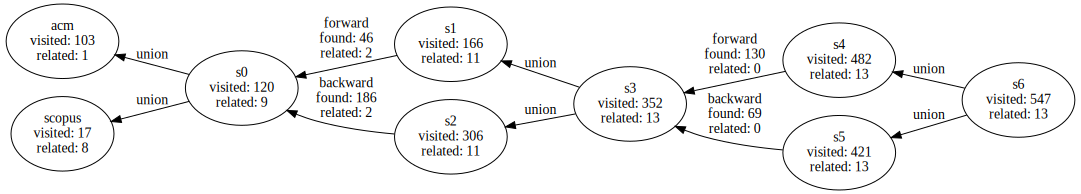

In [31]:
state

In [32]:
# Quantidade de artigo que existe em mais de uma biblioteca, após a união, no Estado S0, Ex, existe 1 artigo em acm e scopus.
state.find("s0").previous[0][1]

(len(strategy.initial.find("acm").visited) + len(strategy.initial.find("scopus").visited)) - len(state.find("s0").visited)

0

In [33]:
# Artigos encontrados via Backward e Forward - Foi incluído kitchenham 2007a como Snowball para o teste.
print ("Encontrados via Backward e Forward:")
separa_backward_forward(state) @ metakey_title

Encontrados via Backward e Forward:


[['trienekens2009a - Entropy based software processes improvement',
  'basili2010a - Linking software development and business strategy through measurement'],
 ['petersen2015a - An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI)',
  'mandić2010a - Utilizing GQM+ Strategies for an organization-wide earned value analysis']]

In [34]:
def duplicados(strategy, state):
    encontrados = set()
    result = set()
    soma = 0
    related = state.related - state.find("s0").related
    for work in state.related:
        inter = encontrados & (set(strategy.ref[work]) & related)
        if inter:
            soma += len(inter)
            encontrados |= inter
            print(work @ metakey, "backward", inter @ metakey)
        inter = encontrados & (set(strategy.rev_ref[work]) & related)
        if inter:
            soma += len(inter)
            encontrados |= inter
            print(work @ metakey, "forward", inter @ metakey)
    return soma

In [35]:
strategy.forward??

In [36]:
duplicados(strategy, state)

0

<IPython.core.display.Javascript object>


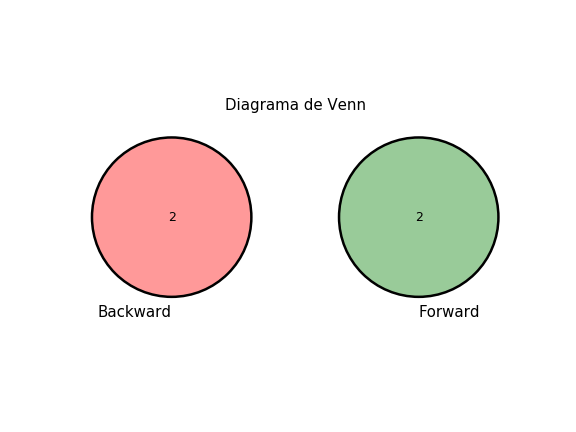

In [39]:
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
v = venn2(sets, set_labels = ('Backward', 'Forward'))
c = venn2_circles(sets)
plt.title('Diagrama de Venn')
plt.show()

In [40]:
#Backward - Execução de backward em sets[0]
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)

Backward ['trienekens2009a', 'basili2010a']
Forward ['petersen2015a', 'mandić2010a']


In [41]:
state.find("s0").related @ metakey

['reiblein1997a',
 'martins2008a',
 'plösch2011a',
 'albuquerque2009a',
 'becker2008a',
 'wilkie2007a',
 'guzmán2010a',
 'mandić2010b',
 'kaneko2011a']

In [42]:
#x = v.get_patch_by_id('100')

In [43]:
#x.set_linestyle = "black"

In [44]:
#[x.metakey for x in state.find("s0").related]

#### Execução de Backward (Aresta S0 -> S2) em cada artigo relacionado do S0

In [45]:
print("Descreve o S0 -> S2:\n Execução de Backward em cada artigo do related \n")
descreve_delta(strategy, state, "s2")

Descreve o S0 -> S2:
 Execução de Backward em cada artigo do related 

backward reiblein1997a
- hinley1997a 
- group1997a 
- humphrey1989a 
- kaplan1993a 
- miller1995a 
- cmm1993a 
- kaplan1996b 
- vlasveld1995a 
- iso1994a 
- trade1992a 
- iso1994b 
- deming1986a 
- isoies1997a 
- itil1989a 
backward martins2008a
- pfleeger1994a 
- paulk1993a 
- krasner1997a 
- solingen1999a 
- emam1999a 
- isoiec1998a 
- arthur1993a 
- cmm2002a 
- isoiec1998c 
- kuvaja1994a 
- vertage1994a 
- isoiec1998b 
- martins2007b 
- salo2005a 
backward plösch2011a
- cmmi2006a 
- simon2002a 
- isoiec1998d 
- venzin2003a 
- mcfeeley1996a 
- isoiec2003b 
- dion1993a 
- shewhart1931a 
backward albuquerque2009a
- nollen2008a 
- komi2004a 
- wright2000a 
- boehm2000b 
- reed2000a 
- isoiec2004b 
- stalhane2004a 
- softex2009a 
- dybå2003b 
- martins2007b 
- prahalad1999a 
- hefner2001a 
- birk2002a 
- thompson2000a 
- kaplan2000a 
- adams1993a 
- bardin1977a 
- caivano2005a 
- cater2004a 
- kim1995a 
- salo2005b 
-

#### Execução de Forward em cada artigo relacionado do S1

In [46]:
print("Descreve o S0 -> S1:\n Execução de Forward em cada artigo do related \n")
descreve_delta(strategy, state, "s1")

Descreve o S0 -> S1:
 Execução de Forward em cada artigo do related 

forward becker2008a
- spósito2016a 
forward wilkie2007a
- sánchez2016a 
- zarour2009a 
- zarour2011a 
- zarour2009b 
- al2013a 
- lester2007a 
- taylor2009a 
- laporte2009a 
- napier2009a 
- lester2010a 
forward guzmán2010a
- cyrus2011a 
- pryor2011a 
- lepmets2012a 
- sanchez2018a 
- barreto2011a 
- valenciennes2013a 
- salgado2015a 
- haghighatfar2013a 
- aguirre2014a 
- dadhich2012a 
- mitre2014a 
- hamouda2013a 
- becker2012a 
- sanchez2017a 
- robles2016a 
- lópez2012a 
- ramos2015a 
- vasconcellos2017a 
- mitrehernández2014a 
forward mandić2010b
- petersen2015a related
- mandić2010a related
forward kaneko2011a
- razón2014b 
- heidrich2012b 
- watanabe2017a 
- trinkenreich2017a 
- trinkenreich2015a 
- asghari2012a 
- aoki2016a 
- kobori2016a 
- tomaz2017 
- teixeira2013a 
- kobori2014a 
- razón2014a 
- mandić2017a 
- petersen2015a related
- lópez2016a 


#### Resumo do Precision e Recall

In [54]:
E2P = len (strategy.initial.related) / len (strategy.initial.visited)
#print (len (strategy.initial.related))
#print (len (strategy.initial.visited))
#print (E2P)
print ("Precision na Busca E2: %.2f%%" % E2P)

#print ("Precision no Snowballing - E2:")
#print(len(state.related - state.find("s0").related))
#print(len(state.visited - state.find("s0").visited))

E2PS = len(state.related - state.find("s0").related) / len(state.visited - state.find("s0").visited)

print ("\n""Precision no Snowballing E2: %.2f%%" % E2PS)

print("Precision no Snowballing E2 - Forward - 1 iteração: %.2f%%" % (len (state.find("s1").delta_related) / len (state.find("s1").delta_visited)))

print("Precision no Snowballing E2 - Backward - 1 iteração: %.2f%%" % (len (state.find("s2").delta_related) / len (state.find("s2").delta_visited)))

print("\n""Precision E2 (Busca + Snowballing): %.2f%%" % (len(state.related) / len(state.visited)))

#len (state.find("s1").related)

#len (state.find("s1").delta_related)
#len (state.find("s1").delta_visited)


name = "E2"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision na Busca E2: 0.07%

Precision no Snowballing E2: 0.01%
Precision no Snowballing E2 - Forward - 1 iteração: 0.04%
Precision no Snowballing E2 - Backward - 1 iteração: 0.01%

Precision E2 (Busca + Snowballing): 0.02%
Precision E2
0.02376599634369287
Recall E2
0.5909090909090909


In [55]:
0 /0 

ZeroDivisionError: division by zero

In [56]:
from collections import deque
def precision_recall(state, total, stop=""):
    # Precisao 0 quando nao visita nada
    array = [[
        "state", "precision", "recall", "operation", 
        "related", "visited", "delta_related", "delta_visited",
        "accumulated_precision", "accumulated_recall",
    ]]
    stack = deque([state])
    visited = {id(state)}
    while stack:
        current = stack.pop()
        try:
            accumulated_precision = len(current.related) / len(current.visited)
            precision = len(current.delta_related) / len(current.delta_visited)
        except ZeroDivisionError:
            precision = 0.0
            
        array.append([
            current.name,
            precision,
            len(current.delta_related) / len(total),
            current.previous[1] if current.previous else "-",
            len(current.related),
            len(current.visited),
            len(current.delta_related),
            len(current.delta_visited),
            accumulated_precision,
            len(current.related) / len(total),
        ])
        if current.name == stop:
            break
        if current.previous:              
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.appendleft(previous)
    return array

In [57]:
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
df

9,state,precision,recall,operation,related,visited,delta_related,delta_visited,accumulated_precision,accumulated_recall
0,scopus,0.470588,0.363636,-,8,17,8,17,0.470588,0.363636
1,acm,0.00970874,0.0454545,-,1,103,1,103,0.00970874,0.0454545
2,s0,0,0,union,9,120,0,0,0.075,0.409091
3,s2,0.0107527,0.0909091,backward,11,306,2,186,0.0359477,0.5
4,s1,0.0434783,0.0909091,forward,11,166,2,46,0.0662651,0.5
5,s3,0,0,union,13,352,0,0,0.0369318,0.590909
6,s5,0,0,backward,13,421,0,69,0.0308789,0.590909
7,s4,0,0,forward,13,482,0,130,0.026971,0.590909
8,s6,0,0,union,13,547,0,0,0.023766,0.590909


<IPython.core.display.Javascript object>


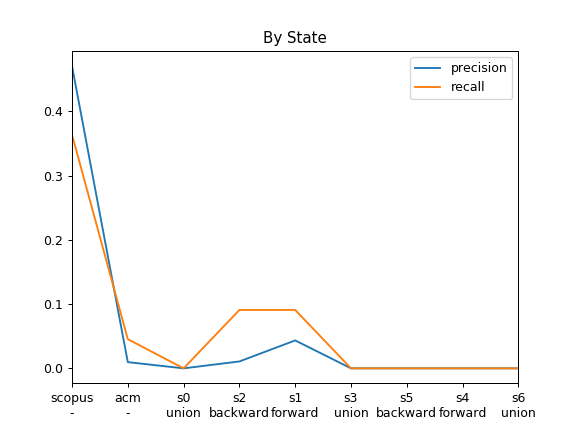

In [58]:
fig = plt.figure()
df['precision'].plot(legend=True)
df['recall'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
ax.set_title("By State");

<IPython.core.display.Javascript object>


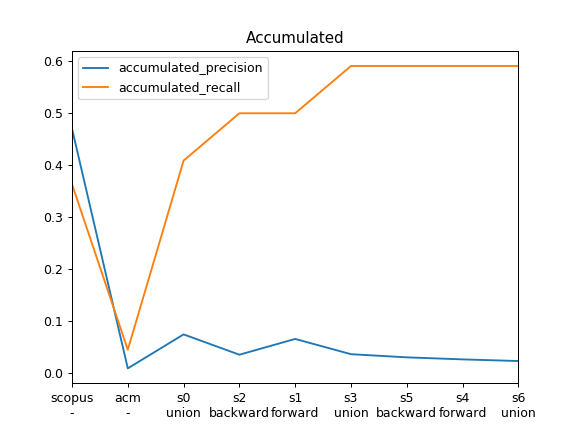

In [59]:
fig = plt.figure()
df['accumulated_precision'].plot(legend=True)
df['accumulated_recall'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
ax.set_title("Accumulated");

## Estratégia 3 - Busca Informal (Google Scholar) + Snowballing (Guideline - sfbu)

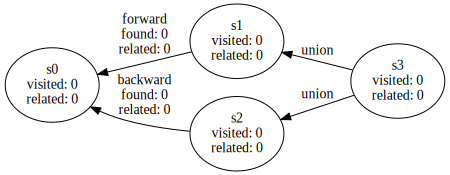

In [60]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("gs", filter_function=filter_function))
state = strategy.sfbu()
state

In [61]:
name = "E3"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E3


ZeroDivisionError: division by zero

## Estratégia 4 - Busca em Scopus + Snowballing (Guideline - sfbu)

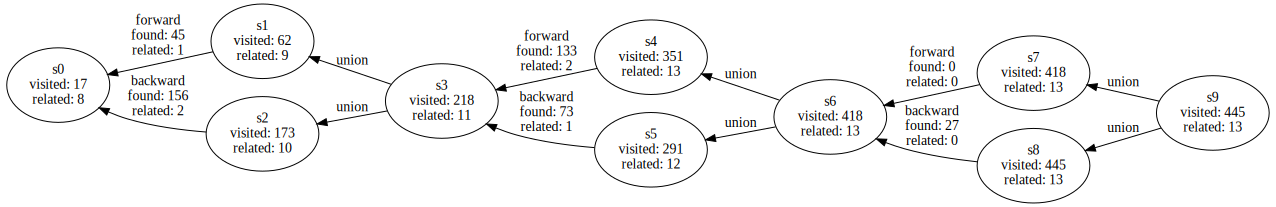

In [62]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.sfbu()
state

In [63]:
name = "E4"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E4
0.029213483146067417
Recall E4
0.5909090909090909


In [64]:
state.find("s0").related

{SPI:I can't get no satisfaction-directing process improvement to meet business needs,
 ProPAMet: a Metric for process and project alignment,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Software process improvement: Supporting the linking of the software and the business strategies,
 An approach to support the strategic alignment of software process improvement programs,
 A Low-overhead method for software process appraisal,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry}

In [65]:
state.find("s2").related

{SPI:I can't get no satisfaction-directing process improvement to meet business needs,
 ProPAMet: a Metric for process and project alignment,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Software process improvement: Supporting the linking of the software and the business strategies,
 An approach to support the strategic alignment of software process improvement programs,
 Entropy based software processes improvement,
 A Low-overhead method for software process appraisal,
 Linking software development and business strategy through measurement,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry}

In [66]:
state.find("s0").visited

{Alignment between the business strategy and the software processes improvement: A roadmap for the implementation [Alinhamento entre estrategia de negocios e melhoria de processos de software: Um roteiro de implementacao],
 ProPAMet: a Metric for process and project alignment,
 Using strategic planning for selection of SPI processes: An experience report,
 Empirical evaluation of selected best practices in implementation of software process improvement,
 Software process improvement: Supporting the linking of the software and the business strategies,
 An approach to support the strategic alignment of software process improvement programs,
 Critical success factors in software process improvement: A systematic review,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 A case study applying process and

In [67]:
# Com backward de mendes2004a é possível encontrar 2 (resultado da celula)
state.related & set(strategy.ref[work_by_varname("mendes2004a")])

set()

In [68]:
# Com backward de ... em S2, encontrou 1 (resultado da celula)
state.find("s2").delta_related & set(strategy.ref[work_by_varname("mendes2004a")])

set()

In [69]:
# Com forward de ... em S1, encontrou 1 (resultado da celula)
state.find("s1").delta_related & set(strategy.rev_ref[work_by_varname("mendes2004a")])

set()

In [70]:
len(state.find("s1").delta_visited)

45

In [71]:
#len(state.find("s1").delta_visited & set(strategy.rev_ref[work_by_varname("mendes2004a")]))
# forward
len(set(strategy.rev_ref[work_by_varname("mendes2004a")]))

0

In [72]:
# backward
len(set(strategy.ref[work_by_varname("mendes2004a")]))

0

In [73]:
search_state = strategy.initial
search_state.related

{SPI:I can't get no satisfaction-directing process improvement to meet business needs,
 ProPAMet: a Metric for process and project alignment,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Software process improvement: Supporting the linking of the software and the business strategies,
 An approach to support the strategic alignment of software process improvement programs,
 A Low-overhead method for software process appraisal,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry}

## Estratégia 5 - Busca em Scopus + Snowballing (Short Paper - s2ffbb2u)

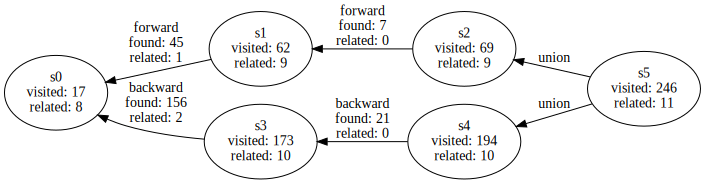

In [74]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.s2bbff2u()
state

In [75]:
name = "E5"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E5
0.044715447154471545
Recall E5
0.5


In [76]:
state.find("s0").related 

{SPI:I can't get no satisfaction-directing process improvement to meet business needs,
 ProPAMet: a Metric for process and project alignment,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Software process improvement: Supporting the linking of the software and the business strategies,
 An approach to support the strategic alignment of software process improvement programs,
 A Low-overhead method for software process appraisal,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry}

In [77]:
state.find("s1").related 

{SPI:I can't get no satisfaction-directing process improvement to meet business needs,
 ProPAMet: a Metric for process and project alignment,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Software process improvement: Supporting the linking of the software and the business strategies,
 An approach to support the strategic alignment of software process improvement programs,
 A Low-overhead method for software process appraisal,
 An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI),
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry}

In [78]:
state.find("s5").related 

{SPI:I can't get no satisfaction-directing process improvement to meet business needs,
 ProPAMet: a Metric for process and project alignment,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Software process improvement: Supporting the linking of the software and the business strategies,
 An approach to support the strategic alignment of software process improvement programs,
 Entropy based software processes improvement,
 A Low-overhead method for software process appraisal,
 An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI),
 Linking software development and business strategy through measurement,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry}

In [79]:
sx, sy = state.previous[0]

sx.related & sy.related


{Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs,
 ProPAMet: a Metric for process and project alignment,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Software process improvement: Supporting the linking of the software and the business strategies,
 An approach to support the strategic alignment of software process improvement programs,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 A Low-overhead method for software process appraisal}

In [80]:
sx.name

's2'

In [81]:
sy.name

's4'

## Estratégia 6 - Busca em Scopus + Snowballing (JF - bbff)

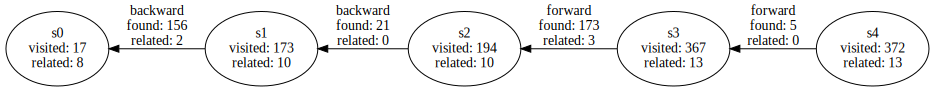

In [82]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.bbff()
state

In [83]:
name = "E6"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E6
0.03494623655913978
Recall E6
0.5909090909090909


## Estratégia 7 - Busca em Scopus + Snowballing (JF - ffbb)

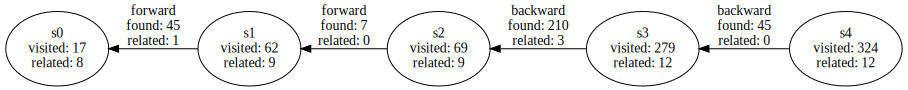

In [84]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.ffbb()
state

In [85]:
name = "E7"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E7
0.037037037037037035
Recall E7
0.5454545454545454


# Análise das Estratégias

In [86]:
%matplotlib notebook
import pandas as pd

In [87]:
df = pd.DataFrame (array,columns = ['Estratégia','Precision','Recall'])
df.index = df['Estratégia']
df

,Estratégia,Precision,Recall
Estratégia,,,
E1,E1,0.470588,0.363636
E2,E2,0.023766,0.590909
E2,E2,0.023766,0.590909
E4,E4,0.029213,0.590909
E5,E5,0.044715,0.500000
E6,E6,0.034946,0.590909
E7,E7,0.037037,0.545455


<IPython.core.display.Javascript object>


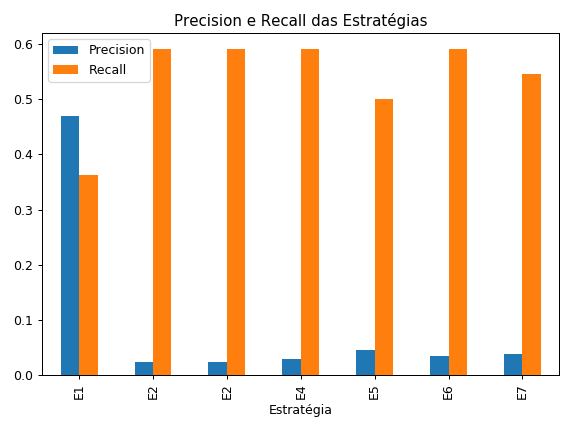

In [88]:
import matplotlib.pyplot as plt
ax = df.plot.bar(title ="Precision e Recall das Estratégias")
plt.tight_layout()


In [89]:
df

,Estratégia,Precision,Recall
Estratégia,,,
E1,E1,0.470588,0.363636
E2,E2,0.023766,0.590909
E2,E2,0.023766,0.590909
E4,E4,0.029213,0.590909
E5,E5,0.044715,0.500000
E6,E6,0.034946,0.590909
E7,E7,0.037037,0.545455


In [90]:
df.to_csv("estrategias.csv")

# Individual

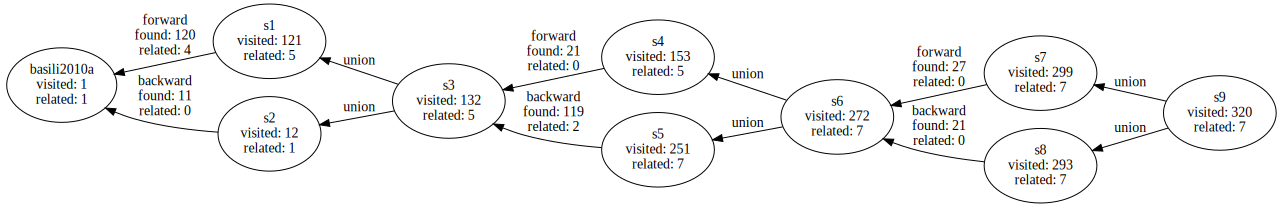

In [91]:
reload()
NAME = "basili2010a"
filter_function = lambda x: x.category in ("snowball", "forward", "backward")
seedset = {work_by_varname(NAME)}
strategy = Strategy(seedset, filter_function)
strategy.initial.name = NAME
state = strategy.sfbu()
state